In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 60.9 MB/s eta 0:00:00


In [ ]:
EXP 5 : Z and N (combined) vs S with no scaler and no optimizer

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.5714 - loss: 101.1355 - val_accuracy: 0.6889 - val_loss: 28.9835
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8615 - loss: 5.4300 - val_accuracy: 0.6222 - val_loss: 28.6034
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9733 - loss: 0.4307 - val_accuracy: 0.6778 - val_loss: 28.3473
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9882 - loss: 0.5636 - val_accuracy: 0.6444 - val_loss: 31.2585
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9988 - loss: 0.1765 - val_accuracy: 0.5111 - val_loss: 39.1905
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9277 - loss: 1.3310 - val_accuracy: 0.6667 - val_loss: 33.7031
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9882 - loss: 0.4598 - val_accuracy: 0.7111 - val_loss: 63.1759
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9901 - loss: 1.6667 - val_accuracy: 0.6889 - val_loss

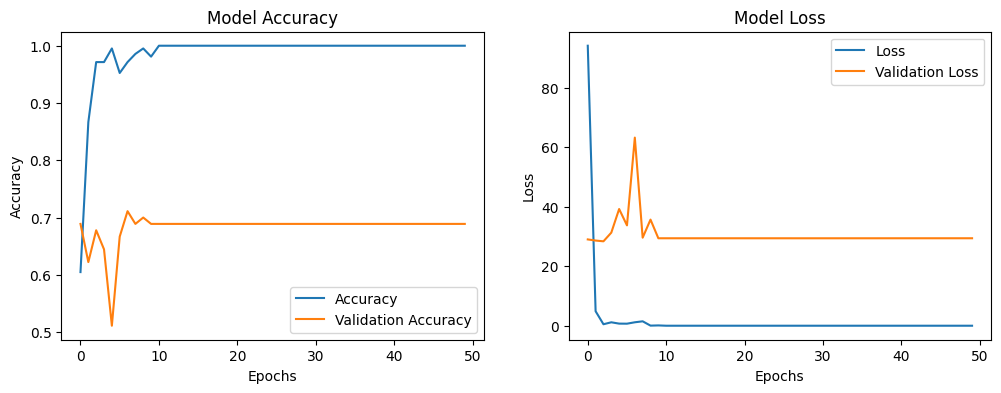

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/ANN/Exp5/No_Options.keras ✅


In [3]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
import pywt
import time

# Define a function to load the data from the directories
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            if file_data.ndim == 1:
                file_data = file_data.reshape(-1, 1)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    data = np.array(data, dtype=object)
    labels = np.array(labels)

    return data, labels

# Define wavelet decomposition preprocessing
def wavelet_decompose(data, wavelet='db4', level=5):
    processed_data = []
    for sample in data:
        coeffs = pywt.wavedec(sample.flatten(), wavelet, level=level)
        processed_sample = np.concatenate(coeffs)  # Concatenate all coefficients
        processed_data.append(processed_sample)
    return np.array(processed_data)

# Paths to your datasets
path_Z = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'
path_N = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'
path_S = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'

# Load data
start_time = time.time()
data_Z, labels_Z = load_data_from_directory(path_Z, label=1)
data_N, labels_N = load_data_from_directory(path_N, label=1)
data_S, labels_S = load_data_from_directory(path_S, label=0)

if data_Z.size > 0 and data_N.size > 0 and data_S.size > 0:
    data_all = np.concatenate((data_Z, data_N, data_S), axis=0)
    labels_all = np.concatenate((labels_Z, labels_N, labels_S), axis=0)

    # Apply wavelet decomposition
    data_all = wavelet_decompose(data_all, wavelet='db4', level=5)

    data_all = data_all.astype(np.float32)
    labels_all = to_categorical(labels_all, num_classes=2)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.3, random_state=42)

    # Define ANN model
    model = Sequential([
        Dense(512, input_dim=X_train.shape[1], activation='relu'),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(2, activation='softmax')
    ])

    model.compile( loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    training_start_time = time.time()
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    training_end_time = time.time()

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    recall = recall_score(y_true_classes, y_pred_classes, average='macro')
    precision = precision_score(y_true_classes, y_pred_classes, average='macro')

    tn, fp, fn, tp = confusion_matrix(y_true_classes, y_pred_classes).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Print metrics
    print("Accuracy:", accuracy)
    print("Recall:", recall)
    print("Precision:", precision)
    print("Sensitivity:", sensitivity)
    print("Specificity:", specificity)

    print("Confusion Matrix:\n", confusion_matrix(y_true_classes, y_pred_classes))

    total_time = time.time() - start_time
    training_time = training_end_time - training_start_time

    print("Total Execution Time (s):", total_time)
    print("Training Time (s):", training_time)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")


        # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/ANN/Exp5/No_Options.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")


with StandardScaler

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.6442 - loss: 0.9412 - val_accuracy: 0.9556 - val_loss: 0.1641
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9853 - loss: 0.0741 - val_accuracy: 0.9667 - val_loss: 0.0841
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 0.0063 - val_accuracy: 0.9556 - val_loss: 0.0840
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.9444 - val_loss: 0.0958
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9444 - val_loss: 0.1069
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 8.0961e-04 - val_accuracy: 0.9556 - val_loss: 0.1177
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 4.9283e-04 - val_accuracy: 0.9556 - val_loss: 0.1285
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 3.2611e-04 - val_accuracy: 0.9556 - val_loss: 0.1368

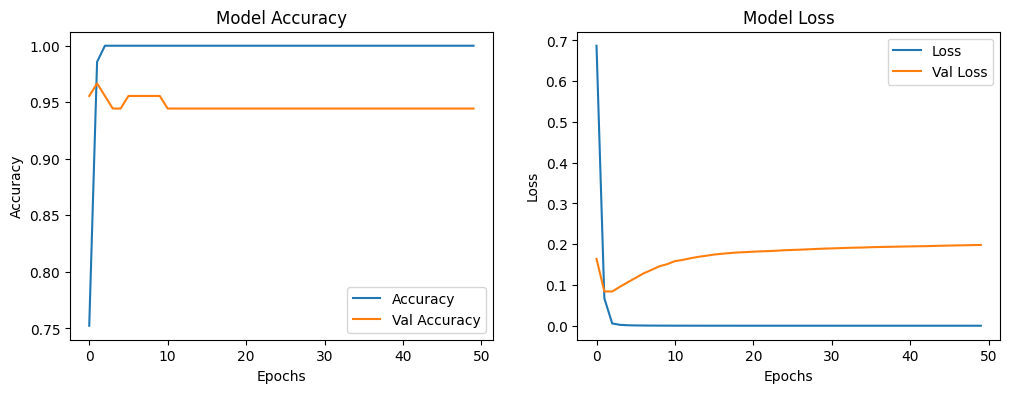

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/ANN/Exp5/With_Stander.keras ✅


In [4]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import pywt
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Define a function to load the data from the directories
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    for filename in files:
        file_path = os.path.join(directory_path, filename)

        try:
            file_data = np.loadtxt(file_path)
            if file_data.ndim == 1:
                file_data = file_data.reshape(-1, 1)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    data = np.array(data, dtype=object)
    labels = np.array(labels)

    return data, labels

# Define a function for wavelet decomposition
def wavelet_decomposition(data, wavelet='db4', level=5):
    processed_data = []
    for sample in data:
        coeffs = pywt.wavedec(sample.flatten(), wavelet, level=level)
        processed_data.append(np.concatenate(coeffs))
    return np.array(processed_data)

# Paths to datasets
path_Z = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'
path_N = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'
path_S = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'

# Load data
data_Z, labels_Z = load_data_from_directory(path_Z, label=1)
data_N, labels_N = load_data_from_directory(path_N, label=1)
data_S, labels_S = load_data_from_directory(path_S, label=0)

if data_Z.size > 0 and data_N.size > 0 and data_S.size > 0:
    data_all = np.concatenate((data_Z, data_N, data_S), axis=0)
    labels_all = np.concatenate((labels_Z, labels_N, labels_S), axis=0)

    # Flatten each sample and apply wavelet decomposition
    data_all = [d.flatten() for d in data_all]
    data_all = wavelet_decomposition(data_all, wavelet='db4', level=5)

    # Standardize the data
    scaler = StandardScaler()
    data_all = scaler.fit_transform(data_all)

    # One-hot encode labels
    labels_all = to_categorical(labels_all, num_classes=2)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.3, random_state=42)

    # Define the model
    model = Sequential([
        Dense(512, input_dim=X_train.shape[1], activation='relu'),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(2, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    end_time = time.time()

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred_classes)
    recall = recall_score(np.argmax(y_test, axis=1), y_pred_classes, average='macro')
    precision = precision_score(np.argmax(y_test, axis=1), y_pred_classes, average='macro')
    conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

    sensitivity = recall  # Sensitivity is equivalent to recall for binary classification
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    execution_time = end_time - start_time

    # Print metrics
    print("Accuracy:", accuracy)
    print("Recall (Sensitivity):", sensitivity)
    print("Precision:", precision)
    print("Specificity:", specificity)
    print("Confusion Matrix:\n", conf_matrix)
    print("Execution Time (s):", execution_time)

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")



       # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/ANN/Exp5/With_Stander.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")


with the optimizer (Adam)

In [5]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
import pywt
import time

# Define a function to load the data from the directories
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            if file_data.ndim == 1:
                file_data = file_data.reshape(-1, 1)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    data = np.array(data, dtype=object)
    labels = np.array(labels)

    return data, labels

# Define wavelet decomposition preprocessing
def wavelet_decompose(data, wavelet='db4', level=5):
    processed_data = []
    for sample in data:
        coeffs = pywt.wavedec(sample.flatten(), wavelet, level=level)
        processed_sample = np.concatenate(coeffs)  # Concatenate all coefficients
        processed_data.append(processed_sample)
    return np.array(processed_data)

# Paths to your datasets
path_Z = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'
path_N = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'
path_S = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'

# Load data
start_time = time.time()
data_Z, labels_Z = load_data_from_directory(path_Z, label=1)
data_N, labels_N = load_data_from_directory(path_N, label=1)
data_S, labels_S = load_data_from_directory(path_S, label=0)

if data_Z.size > 0 and data_N.size > 0 and data_S.size > 0:
    data_all = np.concatenate((data_Z, data_N, data_S), axis=0)
    labels_all = np.concatenate((labels_Z, labels_N, labels_S), axis=0)

    # Apply wavelet decomposition
    data_all = wavelet_decompose(data_all, wavelet='db4', level=5)

    data_all = data_all.astype(np.float32)
    labels_all = to_categorical(labels_all, num_classes=2)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.3, random_state=42)

    # Define ANN model
    model = Sequential([
        Dense(512, input_dim=X_train.shape[1], activation='relu'),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(2, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    training_start_time = time.time()
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    training_end_time = time.time()

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    recall = recall_score(y_true_classes, y_pred_classes, average='macro')
    precision = precision_score(y_true_classes, y_pred_classes, average='macro')

    tn, fp, fn, tp = confusion_matrix(y_true_classes, y_pred_classes).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Print metrics
    print("Accuracy:", accuracy)
    print("Recall:", recall)
    print("Precision:", precision)
    print("Sensitivity:", sensitivity)
    print("Specificity:", specificity)

    print("Confusion Matrix:\n", confusion_matrix(y_true_classes, y_pred_classes))

    total_time = time.time() - start_time
    training_time = training_end_time - training_start_time

    print("Total Execution Time (s):", total_time)
    print("Training Time (s):", training_time)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")



      # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/ANN/Exp5/With_Optimiser.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.5221 - loss: 59.6322 - val_accuracy: 0.5667 - val_loss: 33.1110
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8223 - loss: 9.8780 - val_accuracy: 0.6222 - val_loss: 25.9094
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8808 - loss: 4.1614 - val_accuracy: 0.6000 - val_loss: 39.1405
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9471 - loss: 0.9939 - val_accuracy: 0.6667 - val_loss: 32.5530
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9974 - loss: 0.2197 - val_accuracy: 0.6778 - val_loss: 29.9198
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 9.9341e-10 - val_accuracy: 0.6778 - val_loss: 29.5990
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 1.0344e-08 - val_accuracy: 0.6889 - val_loss: 29.4308
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 5.2406e-08 - val_accuracy: 0.6889 - val_loss

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Accuracy: 0.6888888888888889
Recall: 0.7777777777777778
Precision: 0.7454545454545455
Sensitivity: 0.5555555555555556
Specificity: 1.0
Confusion Matrix:
 [[27  0]
 [28 35]]
Total Execution Time (s): 26.826534032821655
Training Time (s): 25.216948986053467


Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/ANN/Exp5/With_Optimiser.keras ✅


with optimizer and standerscaler

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.6955 - loss: 0.5707 - val_accuracy: 0.9667 - val_loss: 0.1402
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.0250 - val_accuracy: 0.9889 - val_loss: 0.0671
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.9778 - val_loss: 0.0849
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 1.0000 - loss: 1.8641e-04 - val_accuracy: 0.9667 - val_loss: 0.1128
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 1.0000 - loss: 8.0696e-05 - val_accuracy: 0.9556 - val_loss: 0.1339
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 1.0000 - loss: 4.1579e-05 - val_accuracy: 0.9556 - val_loss: 0.1470
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 1.9343e-05 - val_accuracy: 0.9556 - val_loss: 0.1544
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 1.8934e-05 - val_accuracy: 0.9556 - val_loss

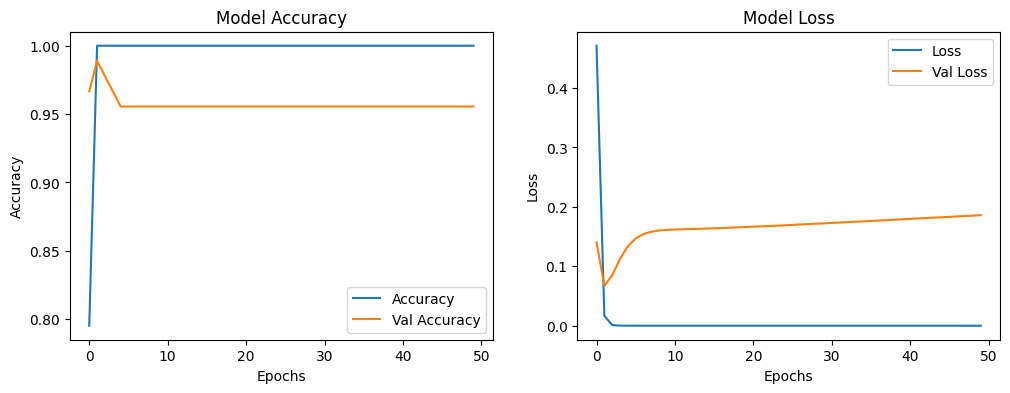

Model saved successfully at /content/drive/MyDrive/Models/Walvet_dec/ANN/Exp5/With_Options.keras ✅


In [6]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import pywt
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Define a function to load the data from the directories
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    for filename in files:
        file_path = os.path.join(directory_path, filename)

        try:
            file_data = np.loadtxt(file_path)
            if file_data.ndim == 1:
                file_data = file_data.reshape(-1, 1)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    data = np.array(data, dtype=object)
    labels = np.array(labels)

    return data, labels

# Define a function for wavelet decomposition
def wavelet_decomposition(data, wavelet='db4', level=5):
    processed_data = []
    for sample in data:
        coeffs = pywt.wavedec(sample.flatten(), wavelet, level=level)
        processed_data.append(np.concatenate(coeffs))
    return np.array(processed_data)

# Paths to datasets
path_Z = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'
path_N = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'
path_S = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'

# Load data
data_Z, labels_Z = load_data_from_directory(path_Z, label=1)
data_N, labels_N = load_data_from_directory(path_N, label=1)
data_S, labels_S = load_data_from_directory(path_S, label=0)

if data_Z.size > 0 and data_N.size > 0 and data_S.size > 0:
    data_all = np.concatenate((data_Z, data_N, data_S), axis=0)
    labels_all = np.concatenate((labels_Z, labels_N, labels_S), axis=0)

    # Flatten each sample and apply wavelet decomposition
    data_all = [d.flatten() for d in data_all]
    data_all = wavelet_decomposition(data_all, wavelet='db4', level=5)

    # Standardize the data
    scaler = StandardScaler()
    data_all = scaler.fit_transform(data_all)

    # One-hot encode labels
    labels_all = to_categorical(labels_all, num_classes=2)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.3, random_state=42)

    # Define the model
    model = Sequential([
        Dense(512, input_dim=X_train.shape[1], activation='relu'),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(2, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    end_time = time.time()

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred_classes)
    recall = recall_score(np.argmax(y_test, axis=1), y_pred_classes, average='macro')
    precision = precision_score(np.argmax(y_test, axis=1), y_pred_classes, average='macro')
    conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

    sensitivity = recall  # Sensitivity is equivalent to recall for binary classification
    specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    execution_time = end_time - start_time

    # Print metrics
    print("Accuracy:", accuracy)
    print("Recall (Sensitivity):", sensitivity)
    print("Precision:", precision)
    print("Specificity:", specificity)
    print("Confusion Matrix:\n", conf_matrix)
    print("Execution Time (s):", execution_time)

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")




           # Define the model path
model_path = "/content/drive/MyDrive/Models/Walvet_dec/ANN/Exp5/With_Options.keras"

# Save the model
model.save(model_path)

print(f"Model saved successfully at {model_path} ✅")
